Best parameters: {'solver': 'sag', 'C': 100.0}
Best cross-validation score: 0.82


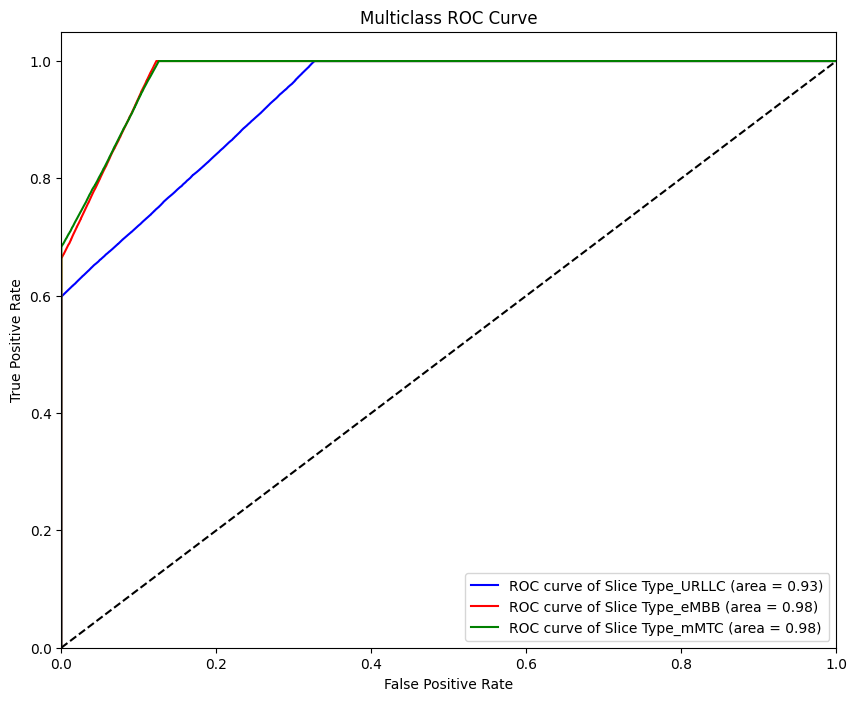

Accuracy on Test set: 0.8197
F1 Score (Weighted Average): 0.8189
Confusion Matrix:
[[47950  6671  8075]
 [ 5941 31819     0]
 [ 4558     0 35008]]
Classification Report:
                  precision    recall  f1-score   support

Slice Type_URLLC       0.82      0.76      0.79     62696
 Slice Type_eMBB       0.83      0.84      0.83     37760
 Slice Type_mMTC       0.81      0.88      0.85     39566

        accuracy                           0.82    140022
       macro avg       0.82      0.83      0.82    140022
    weighted avg       0.82      0.82      0.82    140022



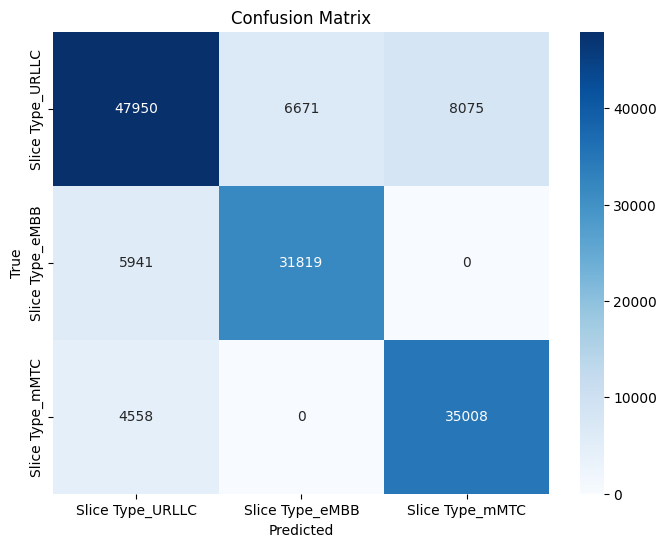

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns  # For plotting

# Load the processed dataset
df = pd.read_csv(r"C:\Users\anifa\Desktop\GITB\EECE5644-Intro_to_ML\Project\Dataset\processed_data_without_packet_loss_delay\processed_data_without_packet_loss_delay.csv")

# Drop any columns that are completely empty or that are just unnamed indices
df.drop(columns=[col for col in df.columns if 'Unnamed' in col or df[col].isna().all()], inplace=True)

# Create a mapping from the combined numerical target to the specific slice type names
class_mapping = {
    0: 'Slice Type_URLLC',
    1: 'Slice Type_eMBB',
    2: 'Slice Type_mMTC'
}

# Apply the mapping to the target column based on the max value across specific columns
df['Slice Type (Output)'] = df[['Slice Type (Output)_URLLC', 'Slice Type (Output)_eMBB', 'Slice Type (Output)_mMTC']].idxmax(axis=1)
df['Slice Type (Output)'] = df['Slice Type (Output)'].map({
    'Slice Type (Output)_URLLC': class_mapping[0],
    'Slice Type (Output)_eMBB': class_mapping[1],
    'Slice Type (Output)_mMTC': class_mapping[2]
})

# Separate features and the combined target
X = df.drop(['Slice Type (Output)_URLLC', 'Slice Type (Output)_eMBB', 'Slice Type (Output)_mMTC', 'Slice Type (Output)'], axis=1)
y = df['Slice Type (Output)']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Use a subset of the data for RandomizedSearchCV
subset_fraction = 0.1  # Using 10% of the data for faster execution
subset_index = np.random.choice(X_train.shape[0], int(X_train.shape[0] * subset_fraction), replace=False)
X_train_subset = X_train[subset_index]
y_train_subset = y_train.iloc[subset_index]

# Define the logistic regression model
model = LogisticRegression(max_iter=10000, multi_class='ovr', tol=0.01)

# Define the parameter distribution
param_distributions = {
    'C': np.logspace(-3, 2, 6),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the subset of training data
random_search.fit(X_train_subset, y_train_subset)

# Get the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, label in enumerate(class_mapping.values()):
    fpr[label], tpr[label], _ = roc_curve(y_test == label, y_prob[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for label, color in zip(class_mapping.values(), ['blue', 'red', 'green']):
    plt.plot(fpr[label], tpr[label], color=color, label=f'ROC curve of {label} (area = {roc_auc[label]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate accuracy, F1 score, and generate confusion matrix and classification report
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred, labels=list(class_mapping.values()))
class_report = classification_report(y_test, y_pred, labels=list(class_mapping.values()))

print(f'Accuracy on Test set: {accuracy:.4f}')
print(f'F1 Score (Weighted Average): {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
